In [1]:
import wandb
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema

In [2]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("WANDB_API_KEY")

In [3]:
# setting the wandb API from Kaggle secrets to avoid manual login
os.environ["WANDB_API_KEY"] = secret_value_0

# uncomment below line for dry run of wandb
os.environ["WANDB_MODE"] = 'dryrun'

In [4]:
if 'WANDB_MODE' in os.environ and os.environ['WANDB_MODE'] == 'dryrun':
    # not really  a dry run, as we need to authenticate
    # and get the artifact
    api = wandb.Api()
    artifact1 = api.artifact('ml-major-project-g3/major-project/covid19-uk-raw-dataset:latest')
    artifact2 = api.artifact('ml-major-project-g3/major-project/covid19-raw-dataset:latest')
else:
    # starting a run on project, entity(team)
    run = wandb.init(entity='ml-major-project-g3', project='major-project',
                 job_type='data-visualisation', save_code=True)
    artifact = run.use_artifact('covid19-uk-raw-dataset:latest')

artifact_dir1 = artifact1.download()
artifact_dir2 = artifact2.download()

In [5]:
!ls artifacts/covid19-raw-dataset:v1

OxCGRT_latest.csv  codebook.md	owid-covid-codebook.csv  owid-covid-data.csv


In [6]:
uk_owid = pd.read_csv("artifacts/covid19-uk-raw-dataset:v0/uk_combined.csv")
world_owid = pd.read_csv("artifacts/covid19-raw-dataset:v1/owid-covid-data.csv")

In [7]:
pd.set_option('display.max_columns', None, 'display.max_rows', 10)

In [8]:
uk_owid.head(10)

,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,C1_School closing,C1_Flag,C2_Workplace closing,C2_Flag,C3_Cancel public events,C3_Flag,C4_Restrictions on gatherings,C4_Flag,C5_Close public transport,C5_Flag,C6_Stay at home requirements,C6_Flag,C7_Restrictions on internal movement,C7_Flag,C8_International travel controls,E1_Income support,E1_Flag,E2_Debt/contract relief,E3_Fiscal measures,E4_International support,H1_Public information campaigns,H1_Flag,H2_Testing policy,H3_Contact tracing,H4_Emergency investment in healthcare,H5_Investment in vaccines,H6_Facial Coverings,H6_Flag,H7_Vaccination policy,H7_Flag,H8_Protection of elderly people,H8_Flag,M1_Wildcard,StringencyIndex,StringencyIndexForDisplay,StringencyLegacyIndex,StringencyLegacyIndexForDisplay,GovernmentResponseIndex,GovernmentResponseIndexForDisplay,ContainmentHealthIndex,ContainmentHealthIndexForDisplay,EconomicSupportIndex,EconomicSupportIndexForDisplay
0,2020-01-31,2.0,2.0,NaN,NaN,NaN,NaN,0.029,0.029,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,67886004.0,272.898,40.8,18.517,12.527,39753.244,0.2,122.137,4.28,20.0,24.7,NaN,2.54,81.32,0.932,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,2.0,0.0,1.0,2.0,0.0,0.00,0.0,NaN,0.0,NaN,0.0,NaN,NaN,8.33,8.33,9.52,9.52,13.02,13.02,14.88,14.88,0.0,0.0
1,2020-02-01,2.0,0.0,NaN,NaN,NaN,NaN,0.029,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,67886004.0,272.898,40.8,18.517,12.527,39753.244,0.2,122.137,4.28,20.0,24.7,NaN,2.54,81.32,0.932,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,2.0,0.0,1.0,2.0,0.0,0.00,0.0,NaN,0.0,NaN,0.0,NaN,NaN,8.33,8.33,9.52,9.52,13.02,13.02,14.88,14.88,0.0,0.0
2,2020-02-02,2.0,0.0,NaN,NaN,NaN,NaN,0.029,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.11,67886004.0,272.898,40.8,18.517,12.527,39753.244,0.2,122.137,4.28,20.0,24.7,NaN,2.54,81.32,0.932,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,2.0,1.0,1.0,2.0,0.0,0.00,0.0,NaN,0.0,NaN,0.0,NaN,NaN,11.11,11.11,14.29,14.29,14.58,14.58,16.67,16.67,0.0,0.0
3,2020-02-03,8.0,6.0,NaN,NaN,NaN,NaN,0.118,0.088,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.11,67886004.0,272.898,40.8,18.517,12.527,39753.244,0.2,122.137,4.28,20.0,24.7,NaN,2.54,81.32,0.932,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,2.0,1.0,1.0,2.0,0.0,26014287.82,0.0,NaN,0.0,NaN,0.0,NaN,NaN,11.11,11.11,14.29,14.29,14.58,14.58,16.67,16.67,0.0,0.0
4,2020-02-04,8.0,0.0,NaN,NaN,NaN,NaN,0.118,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [9]:
# convert 'date' to datetime type
uk_owid['date'] = pd.to_datetime(uk_owid['date'], format='%Y-%m-%d')

In [10]:
uk_owid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 472 entries, 0 to 471
Data columns (total 99 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   date                                   472 non-null    datetime64[ns]
 1   total_cases                            441 non-null    float64       
 2   new_cases                              441 non-null    float64       
 3   new_cases_smoothed                     436 non-null    float64       
 4   total_deaths                           406 non-null    float64       
 5   new_deaths                             406 non-null    float64       
 6   new_deaths_smoothed                    436 non-null    float64       
 7   total_cases_per_million                441 non-null    float64       
 8   new_cases_per_million                  441 non-null    float64       
 9   new_cases_smoothed_per_million         436 non-null    float64   

In [11]:
uk_owid.drop('tests_units', axis=1, inplace=True)

In [12]:
# sort dataframe according to date
uk_owid.sort_values(by=['date'], ascending=True, inplace=True)

In [13]:
# Find indices of null values for new_cases and new_deaths
new_cases_null_inds = uk_owid[uk_owid['new_cases'].isnull()].date.values
new_cases_null_inds

array(['2020-01-01T00:00:00.000000000', '2020-01-02T00:00:00.000000000',
       '2020-01-03T00:00:00.000000000', '2020-01-04T00:00:00.000000000',
       '2020-01-05T00:00:00.000000000', '2020-01-06T00:00:00.000000000',
       '2020-01-07T00:00:00.000000000', '2020-01-08T00:00:00.000000000',
       '2020-01-09T00:00:00.000000000', '2020-01-10T00:00:00.000000000',
       '2020-01-11T00:00:00.000000000', '2020-01-12T00:00:00.000000000',
       '2020-01-13T00:00:00.000000000', '2020-01-14T00:00:00.000000000',
       '2020-01-15T00:00:00.000000000', '2020-01-16T00:00:00.000000000',
       '2020-01-17T00:00:00.000000000', '2020-01-18T00:00:00.000000000',
       '2020-01-19T00:00:00.000000000', '2020-01-20T00:00:00.000000000',
       '2020-01-21T00:00:00.000000000', '2020-01-22T00:00:00.000000000',
       '2020-01-23T00:00:00.000000000', '2020-01-24T00:00:00.000000000',
       '2020-01-25T00:00:00.000000000', '2020-01-26T00:00:00.000000000',
       '2020-01-27T00:00:00.000000000', '2020-01-28

In [14]:
new_deaths_null_inds = uk_owid[uk_owid['new_deaths'].isnull()].date.values
new_deaths_null_inds

array(['2020-01-01T00:00:00.000000000', '2020-01-02T00:00:00.000000000',
       '2020-01-03T00:00:00.000000000', '2020-01-04T00:00:00.000000000',
       '2020-01-05T00:00:00.000000000', '2020-01-06T00:00:00.000000000',
       '2020-01-07T00:00:00.000000000', '2020-01-08T00:00:00.000000000',
       '2020-01-09T00:00:00.000000000', '2020-01-10T00:00:00.000000000',
       '2020-01-11T00:00:00.000000000', '2020-01-12T00:00:00.000000000',
       '2020-01-13T00:00:00.000000000', '2020-01-14T00:00:00.000000000',
       '2020-01-15T00:00:00.000000000', '2020-01-16T00:00:00.000000000',
       '2020-01-17T00:00:00.000000000', '2020-01-18T00:00:00.000000000',
       '2020-01-19T00:00:00.000000000', '2020-01-20T00:00:00.000000000',
       '2020-01-21T00:00:00.000000000', '2020-01-22T00:00:00.000000000',
       '2020-01-23T00:00:00.000000000', '2020-01-24T00:00:00.000000000',
       '2020-01-25T00:00:00.000000000', '2020-01-26T00:00:00.000000000',
       '2020-01-27T00:00:00.000000000', '2020-01-28

In [15]:
stringency_null_inds = uk_owid[uk_owid['StringencyIndex'].isnull()].date.values
stringency_null_inds

array(['2021-04-16T00:00:00.000000000'], dtype='datetime64[ns]')

In [16]:
# Filling null values for new_cases and new_deaths as 0
values = {'new_cases':0, 'new_deaths':0}
uk_owid.fillna(value=values).head(10)

,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,total_vaccinations,people_vaccinated,people_fully_vaccinated,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,C1_School closing,C1_Flag,C2_Workplace closing,C2_Flag,C3_Cancel public events,C3_Flag,C4_Restrictions on gatherings,C4_Flag,C5_Close public transport,C5_Flag,C6_Stay at home requirements,C6_Flag,C7_Restrictions on internal movement,C7_Flag,C8_International travel controls,E1_Income support,E1_Flag,E2_Debt/contract relief,E3_Fiscal measures,E4_International support,H1_Public information campaigns,H1_Flag,H2_Testing policy,H3_Contact tracing,H4_Emergency investment in healthcare,H5_Investment in vaccines,H6_Facial Coverings,H6_Flag,H7_Vaccination policy,H7_Flag,H8_Protection of elderly people,H8_Flag,M1_Wildcard,StringencyIndex,StringencyIndexForDisplay,StringencyLegacyIndex,StringencyLegacyIndexForDisplay,GovernmentResponseIndex,GovernmentResponseIndexForDisplay,ContainmentHealthIndex,ContainmentHealthIndexForDisplay,EconomicSupportIndex,EconomicSupportIndexForDisplay
441,2020-01-01,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
442,2020-01-02,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
443,2020-01-03,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
444,2020-01-04,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
445,2020-01-05,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,

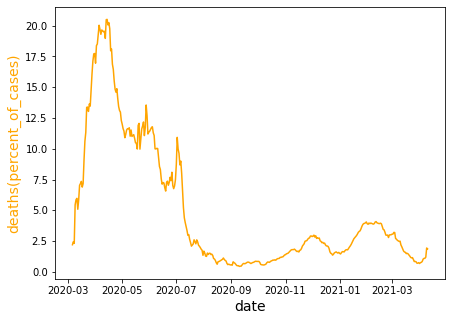

In [17]:
cases_str = 'new_cases_smoothed'
deaths_str = 'new_deaths_smoothed'

cases_deaths_df = uk_owid.loc[:,['date', cases_str, deaths_str]]
cases_deaths_df = cases_deaths_df[(cases_deaths_df['date'] > '2020-03-05') & (cases_deaths_df['date'] < '2021-04-16')]
cases_deaths_df['percent_of_cases'] = (cases_deaths_df[deaths_str].shift(-5)*100)/cases_deaths_df[cases_str]
fig,ax = plt.subplots()
fig.set_size_inches(7, 5)
ax.plot(cases_deaths_df['date'], cases_deaths_df['percent_of_cases'], color="orange")
ax.set_xlabel("date",fontsize=14)
ax.set_ylabel('deaths(percent_of_cases)',color="orange",fontsize=14)
plt.show()
# g.fig.autofmt_xdate()


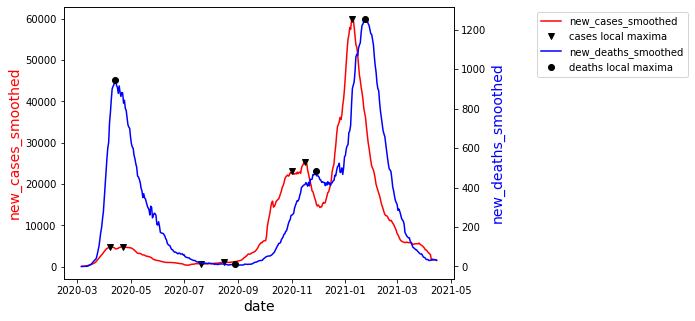

In [18]:
# finding peaks in new_deaths and new_cases
cases_ilocs_max = argrelextrema(cases_deaths_df[cases_str].values, np.greater_equal, order=10)[0]
deaths_ilocs_max = argrelextrema(cases_deaths_df[deaths_str].values, np.greater_equal, order=10)[0]


fig,ax = plt.subplots()
fig.set_size_inches(7, 5)
l1 = ax.plot(cases_deaths_df['date'], cases_deaths_df[cases_str], color="red",label=cases_str)
l2 = ax.plot(cases_deaths_df['date'].iloc[cases_ilocs_max], cases_deaths_df[cases_str].iloc[cases_ilocs_max], lw=0, color='black', marker="v", label='cases local maxima')
ax.set_xlabel("date",fontsize=14)
ax.set_ylabel(cases_str,color="red",fontsize=14)
ax.legend()

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
l3 = ax2.plot(cases_deaths_df['date'], cases_deaths_df[deaths_str], color="blue", label=deaths_str)
l4 = ax2.plot(cases_deaths_df['date'].iloc[deaths_ilocs_max], cases_deaths_df[deaths_str].iloc[deaths_ilocs_max], lw=0, color='black', marker="o", label='deaths local maxima')
ax2.set_ylabel(deaths_str,color="blue",fontsize=14)
# ax2.legend(loc=1)

lns = l1+l2+l3+l4
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, bbox_to_anchor=(1.2,1), loc="upper left")
plt.show()
# # save the plot as a file
# fig.savefig('two_different_y_axis_for_single_python_plot_with_twinx.jpg',
#             format='jpeg',
#             dpi=100,
#             bbox_inches='tight')

In [19]:
print(f"cases max dates:\n{cases_deaths_df['date'].iloc[cases_ilocs_max]}\n")
print(f"deaths max dates:\n{cases_deaths_df['date'].iloc[deaths_ilocs_max]}\n")

cases max dates:
68    2020-04-08
82    2020-04-22
171   2020-07-20
197   2020-08-15
275   2020-11-01
290   2020-11-16
344   2021-01-09
Name: date, dtype: datetime64[ns]

deaths max dates:
73    2020-04-13
210   2020-08-28
302   2020-11-28
358   2021-01-23
Name: date, dtype: datetime64[ns]



In [20]:
degrees = 45

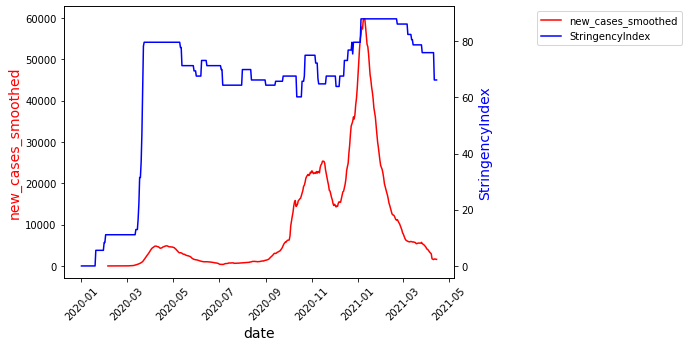

In [21]:
# cases overlaid with stringency index
index_considered = 'StringencyIndex'
fig,ax = plt.subplots()
fig.set_size_inches(7, 5)
plt.xticks(rotation=degrees)
l1 = ax.plot(uk_owid['date'], uk_owid[cases_str], color="red",label=cases_str)
# l2 = ax.plot(['date'].iloc[cases_ilocs_max], cases_deaths_df[cases_str].iloc[cases_ilocs_max], lw=0, color='black', marker="v", label='cases local maxima')
ax.set_xlabel("date",fontsize=14)
ax.set_ylabel(cases_str,color="red",fontsize=14)
ax.legend()

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
l3 = ax2.plot(uk_owid['date'], uk_owid[index_considered], color="blue", label=index_considered)
# l4 = ax2.plot(cases_deaths_df['date'].iloc[deaths_ilocs_max], cases_deaths_df[deaths_str].iloc[deaths_ilocs_max], lw=0, color='black', marker="o", label='deaths local maxima')
ax2.set_ylabel(index_considered,color="blue",fontsize=14)
# ax2.legend(loc=1)

lns = l1+l3
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, bbox_to_anchor=(1.2,1), loc="upper left")

plt.show()

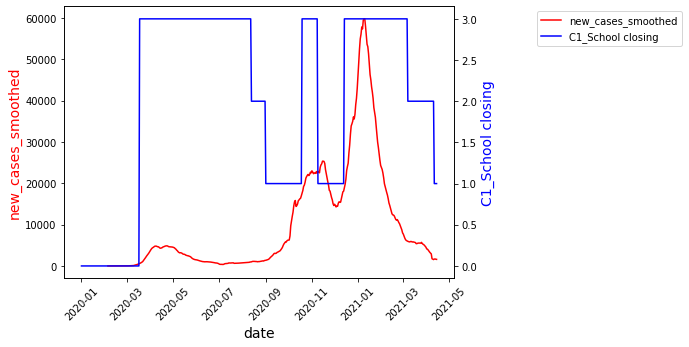

In [22]:
# cases overlaid with C1_School closing

index_considered = 'C1_School closing'
fig,ax = plt.subplots()
fig.set_size_inches(7, 5)
plt.xticks(rotation=degrees)
l1 = ax.plot(uk_owid['date'], uk_owid[cases_str], color="red",label=cases_str)
# l2 = ax.plot(['date'].iloc[cases_ilocs_max], cases_deaths_df[cases_str].iloc[cases_ilocs_max], lw=0, color='black', marker="v", label='cases local maxima')
ax.set_xlabel("date",fontsize=14)
ax.set_ylabel(cases_str,color="red",fontsize=14)
ax.legend()

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
l3 = ax2.plot(uk_owid['date'], uk_owid[index_considered], color="blue", label=index_considered)
# l4 = ax2.plot(cases_deaths_df['date'].iloc[deaths_ilocs_max], cases_deaths_df[deaths_str].iloc[deaths_ilocs_max], lw=0, color='black', marker="o", label='deaths local maxima')
ax2.set_ylabel(index_considered,color="blue",fontsize=14)
# ax2.legend(loc=1)

lns = l1+l3
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, bbox_to_anchor=(1.2,1), loc="upper left")

plt.show()

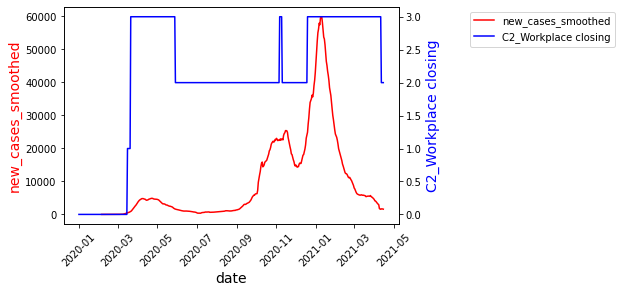

In [23]:
# cases overlaid with C2_Workplace closing

index_considered = 'C2_Workplace closing'
fig,ax = plt.subplots()
plt.xticks(rotation=degrees)
l1 = ax.plot(uk_owid['date'], uk_owid[cases_str], color="red",label=cases_str)
# l2 = ax.plot(['date'].iloc[cases_ilocs_max], cases_deaths_df[cases_str].iloc[cases_ilocs_max], lw=0, color='black', marker="v", label='cases local maxima')
ax.set_xlabel("date",fontsize=14)
ax.set_ylabel(cases_str,color="red",fontsize=14)
ax.legend()

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
l3 = ax2.plot(uk_owid['date'], uk_owid[index_considered], color="blue", label=index_considered)
# l4 = ax2.plot(cases_deaths_df['date'].iloc[deaths_ilocs_max], cases_deaths_df[deaths_str].iloc[deaths_ilocs_max], lw=0, color='black', marker="o", label='deaths local maxima')
ax2.set_ylabel(index_considered,color="blue",fontsize=14)
# ax2.legend(loc=1)

lns = l1+l3
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, bbox_to_anchor=(1.2,1), loc="upper left")

plt.show()

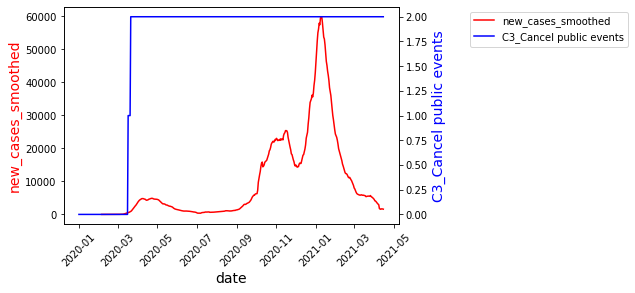

In [24]:
# cases overlaid with C3_Cancel public events

index_considered = 'C3_Cancel public events'
fig,ax = plt.subplots()
plt.xticks(rotation=degrees)
l1 = ax.plot(uk_owid['date'], uk_owid[cases_str], color="red",label=cases_str)
# l2 = ax.plot(['date'].iloc[cases_ilocs_max], cases_deaths_df[cases_str].iloc[cases_ilocs_max], lw=0, color='black', marker="v", label='cases local maxima')
ax.set_xlabel("date",fontsize=14)
ax.set_ylabel(cases_str,color="red",fontsize=14)
ax.legend()

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
l3 = ax2.plot(uk_owid['date'], uk_owid[index_considered], color="blue", label=index_considered)
# l4 = ax2.plot(cases_deaths_df['date'].iloc[deaths_ilocs_max], cases_deaths_df[deaths_str].iloc[deaths_ilocs_max], lw=0, color='black', marker="o", label='deaths local maxima')
ax2.set_ylabel(index_considered,color="blue",fontsize=14)
# ax2.legend(loc=1)

lns = l1+l3
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, bbox_to_anchor=(1.2,1), loc="upper left")

plt.show()

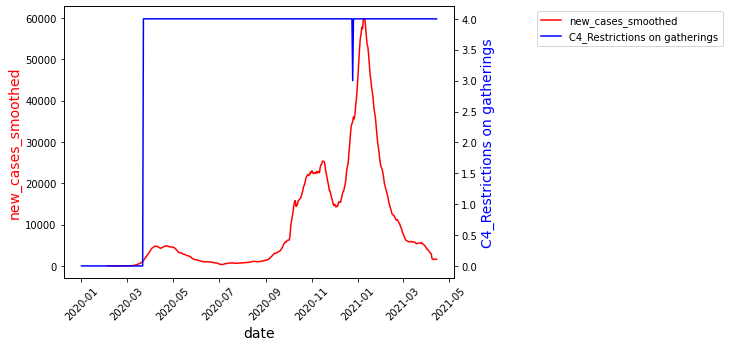

In [25]:
# cases overlaid with C4_Restrictions on gatherings

index_considered = 'C4_Restrictions on gatherings'
fig,ax = plt.subplots()
fig.set_size_inches(7, 5)
plt.xticks(rotation=degrees)
l1 = ax.plot(uk_owid['date'], uk_owid[cases_str], color="red",label=cases_str)
# l2 = ax.plot(['date'].iloc[cases_ilocs_max], cases_deaths_df[cases_str].iloc[cases_ilocs_max], lw=0, color='black', marker="v", label='cases local maxima')
ax.set_xlabel("date",fontsize=14)
ax.set_ylabel(cases_str,color="red",fontsize=14)
ax.legend()

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
l3 = ax2.plot(uk_owid['date'], uk_owid[index_considered], color="blue", label=index_considered)
# l4 = ax2.plot(cases_deaths_df['date'].iloc[deaths_ilocs_max], cases_deaths_df[deaths_str].iloc[deaths_ilocs_max], lw=0, color='black', marker="o", label='deaths local maxima')
ax2.set_ylabel(index_considered,color="blue",fontsize=14)
# ax2.legend(loc=1)

lns = l1+l3
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, bbox_to_anchor=(1.2,1), loc="upper left")

plt.show()

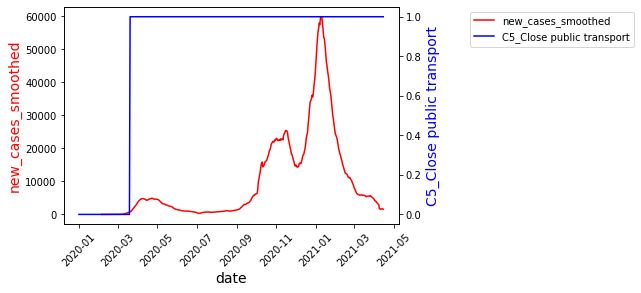

In [26]:
# cases overlaid with C5_Close public transport

index_considered = 'C5_Close public transport'
fig,ax = plt.subplots()
plt.xticks(rotation=degrees)
l1 = ax.plot(uk_owid['date'], uk_owid[cases_str], color="red",label=cases_str)
# l2 = ax.plot(['date'].iloc[cases_ilocs_max], cases_deaths_df[cases_str].iloc[cases_ilocs_max], lw=0, color='black', marker="v", label='cases local maxima')
ax.set_xlabel("date",fontsize=14)
ax.set_ylabel(cases_str,color="red",fontsize=14)
ax.legend()

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
l3 = ax2.plot(uk_owid['date'], uk_owid[index_considered], color="blue", label=index_considered)
# l4 = ax2.plot(cases_deaths_df['date'].iloc[deaths_ilocs_max], cases_deaths_df[deaths_str].iloc[deaths_ilocs_max], lw=0, color='black', marker="o", label='deaths local maxima')
ax2.set_ylabel(index_considered,color="blue",fontsize=14)
# ax2.legend(loc=1)

lns = l1+l3
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, bbox_to_anchor=(1.2,1), loc="upper left")

plt.show()

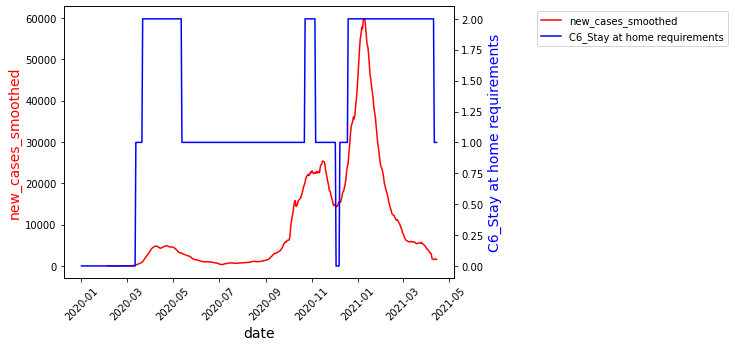

In [27]:
# cases overlaid with C6_Stay at home requirements

index_considered = 'C6_Stay at home requirements'
fig,ax = plt.subplots()
fig.set_size_inches(7, 5)
plt.xticks(rotation=degrees)
l1 = ax.plot(uk_owid['date'], uk_owid[cases_str], color="red",label=cases_str)
# l2 = ax.plot(['date'].iloc[cases_ilocs_max], cases_deaths_df[cases_str].iloc[cases_ilocs_max], lw=0, color='black', marker="v", label='cases local maxima')
ax.set_xlabel("date",fontsize=14)
ax.set_ylabel(cases_str,color="red",fontsize=14)
ax.legend()

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
l3 = ax2.plot(uk_owid['date'], uk_owid[index_considered], color="blue", label=index_considered)
# l4 = ax2.plot(cases_deaths_df['date'].iloc[deaths_ilocs_max], cases_deaths_df[deaths_str].iloc[deaths_ilocs_max], lw=0, color='black', marker="o", label='deaths local maxima')
ax2.set_ylabel(index_considered,color="blue",fontsize=14)
# ax2.legend(loc=1)

lns = l1+l3
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, bbox_to_anchor=(1.2,1), loc="upper left")

plt.show()

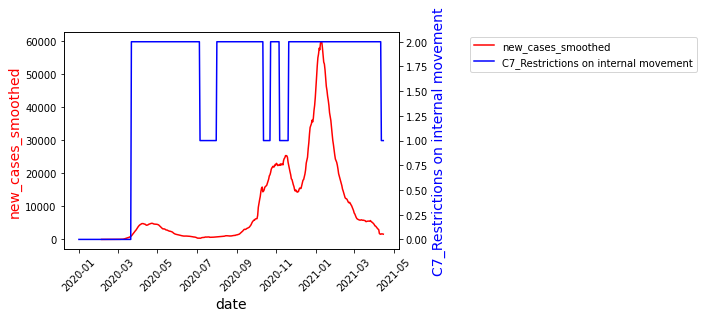

In [28]:
# cases overlaid with C7_Restrictions on internal movement

index_considered = 'C7_Restrictions on internal movement'
fig,ax = plt.subplots()
plt.xticks(rotation=degrees)
l1 = ax.plot(uk_owid['date'], uk_owid[cases_str], color="red",label=cases_str)
# l2 = ax.plot(['date'].iloc[cases_ilocs_max], cases_deaths_df[cases_str].iloc[cases_ilocs_max], lw=0, color='black', marker="v", label='cases local maxima')
ax.set_xlabel("date",fontsize=14)
ax.set_ylabel(cases_str,color="red",fontsize=14)
ax.legend()

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
l3 = ax2.plot(uk_owid['date'], uk_owid[index_considered], color="blue", label=index_considered)
# l4 = ax2.plot(cases_deaths_df['date'].iloc[deaths_ilocs_max], cases_deaths_df[deaths_str].iloc[deaths_ilocs_max], lw=0, color='black', marker="o", label='deaths local maxima')
ax2.set_ylabel(index_considered,color="blue",fontsize=14)
# ax2.legend(loc=1)

lns = l1+l3
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, bbox_to_anchor=(1.2,1), loc="upper left")

plt.show()

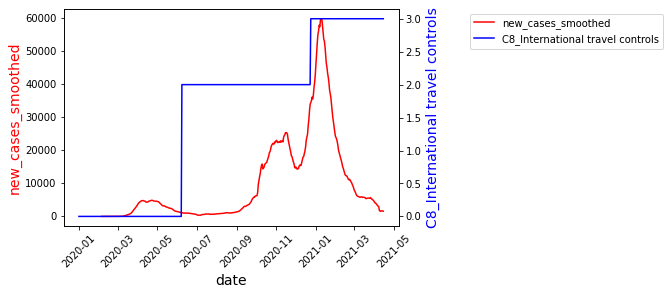

In [29]:
# cases overlaid with C8_International travel controls

index_considered = 'C8_International travel controls'
fig,ax = plt.subplots()
plt.xticks(rotation=degrees)
l1 = ax.plot(uk_owid['date'], uk_owid[cases_str], color="red",label=cases_str)
# l2 = ax.plot(['date'].iloc[cases_ilocs_max], cases_deaths_df[cases_str].iloc[cases_ilocs_max], lw=0, color='black', marker="v", label='cases local maxima')
ax.set_xlabel("date",fontsize=14)
ax.set_ylabel(cases_str,color="red",fontsize=14)
ax.legend()

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
l3 = ax2.plot(uk_owid['date'], uk_owid[index_considered], color="blue", label=index_considered)
# l4 = ax2.plot(cases_deaths_df['date'].iloc[deaths_ilocs_max], cases_deaths_df[deaths_str].iloc[deaths_ilocs_max], lw=0, color='black', marker="o", label='deaths local maxima')
ax2.set_ylabel(index_considered,color="blue",fontsize=14)
# ax2.legend(loc=1)

lns = l1+l3
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, bbox_to_anchor=(1.2,1), loc="upper left")

plt.show()

In [30]:
world_owid.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,AFG,Asia,Afghanistan,2020-02-24,1.0,1.0,NaN,NaN,NaN,NaN,0.026,0.026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
1,AFG,Asia,Afghanistan,2020-02-25,1.0,0.0,NaN,NaN,NaN,NaN,0.026,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
2,AFG,Asia,Afghanistan,2020-02-26,1.0,0.0,NaN,NaN,NaN,NaN,0.026,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
3,AFG,Asia,Afghanistan,2020-02-27,1.0,0.0,NaN,NaN,NaN,NaN,0.026,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
4,AFG,Asia,Afghanistan,2020-02-28,1.0,0.0,NaN,NaN,NaN,NaN,0.026,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511


In [31]:
world_owid['date'] = pd.to_datetime(world_owid['date'], format='%Y-%m-%d')
world_owid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81905 entries, 0 to 81904
Data columns (total 59 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   iso_code                               81905 non-null  object        
 1   continent                              77929 non-null  object        
 2   location                               81905 non-null  object        
 3   date                                   81905 non-null  datetime64[ns]
 4   total_cases                            80087 non-null  float64       
 5   new_cases                              80085 non-null  float64       
 6   new_cases_smoothed                     79084 non-null  float64       
 7   total_deaths                           70548 non-null  float64       
 8   new_deaths                             70706 non-null  float64       
 9   new_deaths_smoothed                    79084 non-null  float6

In [32]:
date_considered = '2021-03-31'
countries_data_on_date = world_owid[(world_owid['date'] == date_considered) & (~world_owid['iso_code'].str.startswith('OWID'))]
countries_data_on_date.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 202 entries, 401 to 81889
Data columns (total 59 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   iso_code                               202 non-null    object        
 1   continent                              202 non-null    object        
 2   location                               202 non-null    object        
 3   date                                   202 non-null    datetime64[ns]
 4   total_cases                            189 non-null    float64       
 5   new_cases                              189 non-null    float64       
 6   new_cases_smoothed                     189 non-null    float64       
 7   total_deaths                           179 non-null    float64       
 8   new_deaths                             179 non-null    float64       
 9   new_deaths_smoothed                    189 non-null    float6

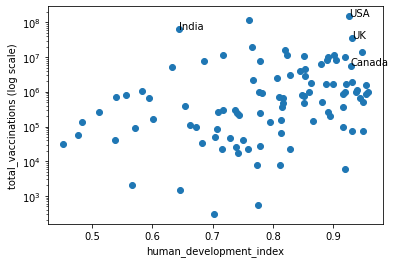

In [33]:
x_value = 'human_development_index'
y_value = 'total_vaccinations'
annotations = {'GBR':'UK', 'IND':'India', 'USA':'USA', 'CAN':'Canada'}
use_log = True

plt.scatter(x=countries_data_on_date[x_value], y=countries_data_on_date[y_value])
if use_log:
    plt.gca().set_yscale('log')

for code in annotations:
    plt.annotate(annotations[code], (countries_data_on_date[countries_data_on_date['iso_code'] == code][x_value],\
                                    countries_data_on_date[countries_data_on_date['iso_code'] == code][y_value]))

plt.xlabel(x_value)

if use_log:
    plt.ylabel(y_value+' (log scale)')
else:
    plt.ylabel(y_value)

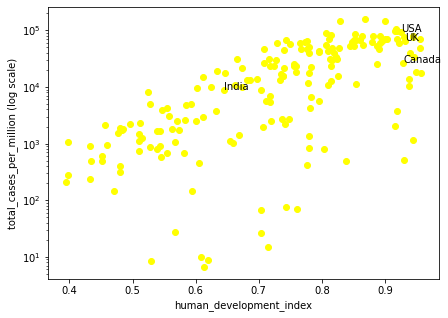

In [34]:
x_value = 'human_development_index'
y_value = 'total_cases_per_million'
annotations = {'GBR':'UK', 'IND':'India', 'USA':'USA', 'CAN':'Canada'}
use_log = True

plt.scatter(x=countries_data_on_date[x_value], y=countries_data_on_date[y_value], color='yellow')
plt.gcf().set_size_inches(7, 5)
if use_log:
    plt.gca().set_yscale('log')

for code in annotations:
    plt.annotate(annotations[code], (countries_data_on_date[countries_data_on_date['iso_code'] == code][x_value],\
                                    countries_data_on_date[countries_data_on_date['iso_code'] == code][y_value]))

plt.xlabel(x_value)

if use_log:
    plt.ylabel(y_value+' (log scale)')
else:
    plt.ylabel(y_value)

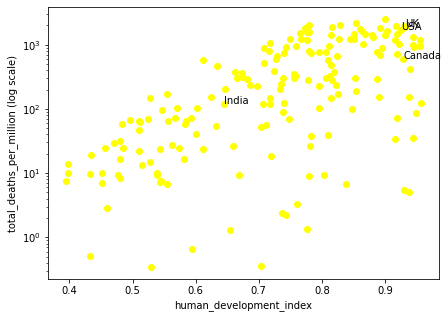

In [35]:
x_value = 'human_development_index'
y_value = 'total_deaths_per_million'
annotations = {'GBR':'UK', 'IND':'India', 'USA':'USA', 'CAN':'Canada'}
use_log = True

plt.scatter(x=countries_data_on_date[x_value], y=countries_data_on_date[y_value], color='yellow')
plt.gcf().set_size_inches(7, 5)
if use_log:
    plt.gca().set_yscale('log')

for code in annotations:
    plt.annotate(annotations[code], (countries_data_on_date[countries_data_on_date['iso_code'] == code][x_value],\
                                    countries_data_on_date[countries_data_on_date['iso_code'] == code][y_value]))

plt.xlabel(x_value)

if use_log:
    plt.ylabel(y_value+' (log scale)')
else:
    plt.ylabel(y_value)

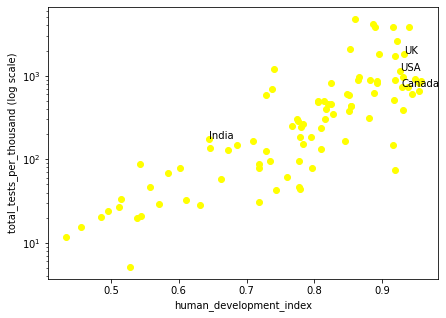

In [36]:
x_value = 'human_development_index'
y_value = 'total_tests_per_thousand'
annotations = {'GBR':'UK', 'IND':'India', 'USA':'USA', 'CAN':'Canada'}
use_log = True

plt.scatter(x=countries_data_on_date[x_value], y=countries_data_on_date[y_value], color='yellow')
plt.gcf().set_size_inches(7, 5)
if use_log:
    plt.gca().set_yscale('log')

for code in annotations:
    plt.annotate(annotations[code], (countries_data_on_date[countries_data_on_date['iso_code'] == code][x_value],\
                                    countries_data_on_date[countries_data_on_date['iso_code'] == code][y_value]))

plt.xlabel(x_value)

if use_log:
    plt.ylabel(y_value+' (log scale)')
else:
    plt.ylabel(y_value)

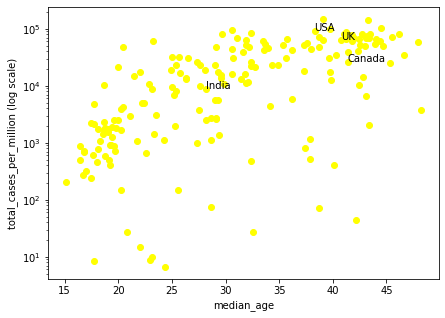

In [37]:
x_value = 'median_age'
y_value = 'total_cases_per_million'
annotations = {'GBR':'UK', 'IND':'India', 'USA':'USA', 'CAN':'Canada'}
use_log = True

plt.scatter(x=countries_data_on_date[x_value], y=countries_data_on_date[y_value], color='yellow')
plt.gcf().set_size_inches(7, 5)
if use_log:
    plt.gca().set_yscale('log')

for code in annotations:
    plt.annotate(annotations[code], (countries_data_on_date[countries_data_on_date['iso_code'] == code][x_value],\
                                    countries_data_on_date[countries_data_on_date['iso_code'] == code][y_value]))

plt.xlabel(x_value)

if use_log:
    plt.ylabel(y_value+' (log scale)')
else:
    plt.ylabel(y_value)

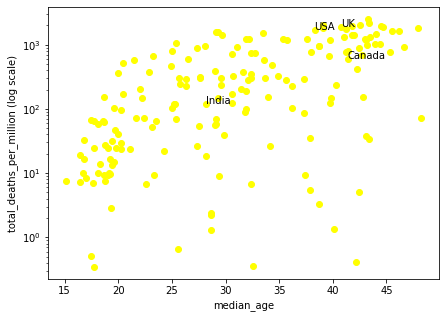

In [38]:
x_value = 'median_age'
y_value = 'total_deaths_per_million'
annotations = {'GBR':'UK', 'IND':'India', 'USA':'USA', 'CAN':'Canada'}
use_log = True

plt.scatter(x=countries_data_on_date[x_value], y=countries_data_on_date[y_value], color='yellow')
plt.gcf().set_size_inches(7, 5)
if use_log:
    plt.gca().set_yscale('log')

for code in annotations:
    plt.annotate(annotations[code], (countries_data_on_date[countries_data_on_date['iso_code'] == code][x_value],\
                                    countries_data_on_date[countries_data_on_date['iso_code'] == code][y_value]))

plt.xlabel(x_value)

if use_log:
    plt.ylabel(y_value+' (log scale)')
else:
    plt.ylabel(y_value)

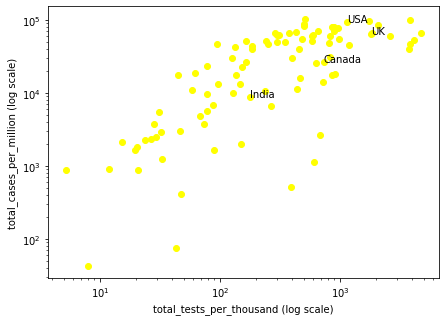

In [39]:
x_value = 'total_tests_per_thousand'
y_value = 'total_cases_per_million'
annotations = {'GBR':'UK', 'IND':'India', 'USA':'USA', 'CAN':'Canada'}
use_log = True

plt.scatter(x=countries_data_on_date[x_value], y=countries_data_on_date[y_value], color='yellow')
plt.gcf().set_size_inches(7, 5)
if use_log:
    plt.gca().set_yscale('log')
    plt.gca().set_xscale('log')
    

for code in annotations:
    plt.annotate(annotations[code], (countries_data_on_date[countries_data_on_date['iso_code'] == code][x_value],\
                                    countries_data_on_date[countries_data_on_date['iso_code'] == code][y_value]))

plt.xlabel(x_value+' (log scale)')

if use_log:
    plt.ylabel(y_value+' (log scale)')
else:
    plt.ylabel(y_value)

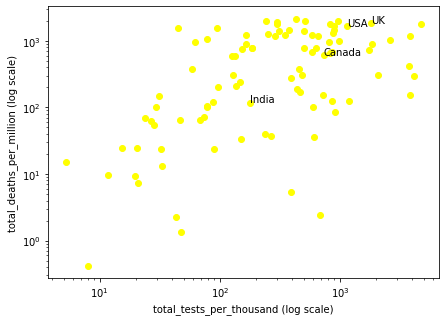

In [40]:
x_value = 'total_tests_per_thousand'
y_value = 'total_deaths_per_million'
annotations = {'GBR':'UK', 'IND':'India', 'USA':'USA', 'CAN':'Canada'}
use_log = True

plt.scatter(x=countries_data_on_date[x_value], y=countries_data_on_date[y_value], color='yellow')
plt.gcf().set_size_inches(7, 5)
if use_log:
    plt.gca().set_yscale('log')
    plt.gca().set_xscale('log')
    

for code in annotations:
    plt.annotate(annotations[code], (countries_data_on_date[countries_data_on_date['iso_code'] == code][x_value],\
                                    countries_data_on_date[countries_data_on_date['iso_code'] == code][y_value]))

plt.xlabel(x_value+' (log scale)')

if use_log:
    plt.ylabel(y_value+' (log scale)')
else:
    plt.ylabel(y_value)

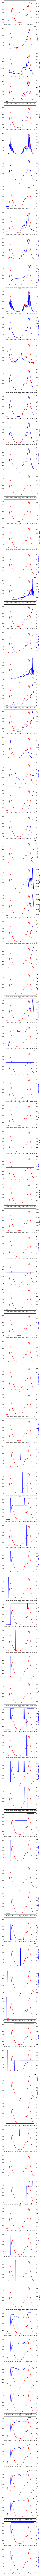

In [41]:
# Plotting all variables vs new_deaths_smoothed for feature selection

main_variable = 'new_deaths_smoothed'

rows = len(uk_owid.columns)
cols = 1
fig,ax = plt.subplots(rows)
fig.set_size_inches(7, 5*rows)
plt.xticks(rotation=degrees)
plt.tight_layout(pad=2, w_pad=2, h_pad=2) 
for i in range(rows):
    ax1 = ax[i]
    # twin object for two different y-axis on the sample plot
    ax2 = ax[i].twinx()
    aux_variable = uk_owid.columns[i]

    l1 = ax1.plot(uk_owid['date'], uk_owid[main_variable], color="red",label=main_variable)
    ax1.set_xlabel("date",fontsize=14)
    ax1.set_ylabel(main_variable, color="red",fontsize=14)

    # make a plot with different y-axis using second axis object
    l3 = ax2.plot(uk_owid['date'], uk_owid[aux_variable], color="blue", label=aux_variable)
    # l4 = ax2.plot(cases_deaths_df['date'].iloc[deaths_ilocs_max], cases_deaths_df[deaths_str].iloc[deaths_ilocs_max], lw=0, color='black', marker="o", label='deaths local maxima')
    ax2.set_ylabel(aux_variable,color="blue",fontsize=14)

    lns = l1+l3
    labs = [l.get_label() for l in lns]
#         ax1.legend(lns, labs, bbox_to_anchor=(1.2,1), loc="upper left")

plt.show()

In [42]:
uk_owid.corr()

,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,total_vaccinations,people_vaccinated,people_fully_vaccinated,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,C1_School closing,C1_Flag,C2_Workplace closing,C2_Flag,C3_Cancel public events,C3_Flag,C4_Restrictions on gatherings,C4_Flag,C5_Close public transport,C5_Flag,C6_Stay at home requirements,C6_Flag,C7_Restrictions on internal movement,C7_Flag,C8_International travel controls,E1_Income support,E1_Flag,E2_Debt/contract relief,E3_Fiscal measures,E4_International support,H1_Public information campaigns,H1_Flag,H2_Testing policy,H3_Contact tracing,H4_Emergency investment in healthcare,H5_Investment in vaccines,H6_Facial Coverings,H6_Flag,H7_Vaccination policy,H7_Flag,H8_Protection of elderly people,H8_Flag,M1_Wildcard,StringencyIndex,StringencyIndexForDisplay,StringencyLegacyIndex,StringencyLegacyIndexForDisplay,GovernmentResponseIndex,GovernmentResponseIndexForDisplay,ContainmentHealthIndex,ContainmentHealthIndexForDisplay,EconomicSupportIndex,EconomicSupportIndexForDisplay
total_cases,1.000000,0.415954,0.454665,0.965686,0.284448,0.383852,1.000000,0.415954,0.454665,0.965686,0.284449,0.383852,-0.411534,0.472411,0.472410,0.485623,0.485623,NaN,NaN,0.337993,0.337993,0.843669,0.963007,0.963007,0.843668,0.907593,0.907594,-0.152203,0.210178,0.888039,0.919781,0.583223,0.319216,0.755801,0.888039,0.919777,0.583140,0.755802,0.496985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.194207,-0.080373,0.512952,-0.300772,0.300315,0.046968,0.309341,0.304186,0.300224,NaN,0.575958,0.143267,0.336029,0.437373,0.756656,0.300224,0.116825,0.295096,-0.051853,-0.061790,NaN,0.057347,0.459761,-0.120258,-0.051626,0.017151,0.620622,0.804125,0.937846,NaN,0.155903,0.229649,NaN,0.496985,0.496985,0.475892,0.475892,0.558882,0.558882,0.611569,0.611569,0.303869,0.303869
new_cases,0.415954,1.000000,0.979533,0.283264,0.576393,0.586691,0.415954,1.000000,0.979533,0.283264,0.576391,0.586691,-0.062944,0.547188,0.547187,0.752366,0.752366,NaN,NaN,0.760558,0.760558,0.233132,0.263584,0.263584,0.233132,0.207479,0.207484,0.361965,-0.481276,-0.849357,-0.885476,-0.531781,-0.255008,-0.732032,-0.849357,-0.885468,-0.531697,-0.732035,0.378405,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.214013,0.157222,0.341217,-0.117894,0.258970,0.036275,0.262565,0.347704,0.258546,NaN,0.393163,0.178714,0.243524,0.183615,0.463196,0.258546,0.084262,0.255016,-0.012602,-0.057142,NaN,0.050023,0.331446,-0.179846,-0.045627,0.054568,0.489770,0.615695,0.443855,NaN,0.298513,0.033456,NaN,0.378405,0.378405,0.365691,0.365691,0.412488,0.412488,0.442100,0.442100,0.261443,0.261443
new_cases_smoothed,0.454665,0.979533,1.000000,0.323367,0.617003,0.648811,0.454665,0.979533,1.000000,0.323367,0.617001,0.648811,-0.123730,0.613391,0.613391,0.808152,0.808152,NaN,NaN,0.813539,0.813539,0.253527,0.293554,0.293554,0.253527,0.238264,0.238270,0.354460,-0.484048,-0.865926,-0.903200,-0.540118,-0.305822,-0.736778,-0.865928,-0.903193,-0.540022,-0.736780,0.397173,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN